In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
import numpy as np

class GMM():
    def __init__(self, n_components, data):
        self.num_data = data.shape[0]
        self.dimension = data.shape[1]
        self.data = data
        self.components = n_components
        self.means = self.initialize_means()
        self.covariances = self.initialize_variances()
        self.lambdas = self.initialize_lambdas()
            
    
    def initialize_means(self): 
        random_choice = np.random.choice(self.num_data, self.components, replace = False)
        means_ = self.data[random_choice]
        return means_
        
    def initialize_variances(self):
        covariances_ = np.zeros((self.components, self.dimension, self.dimension))
        for i in range(self.components):
            covariances_[i] = np.cov(self.data, rowvar = False)
        return covariances_    
    
    def initialize_lambdas(self):
        return np.ones([self.components]) / float(self.components)
        
        
    def initialize_gammas(self):
        """Initializes gammas to random values maintaining their sum = 1 for each component"""
        gammas_ = np.random.rand(self.components, self.num_data)
        gammas_ = gammas_ / gammas_.sum(0)
        return gammas_
        
    def calculate_means(self):
        """Calculates the means based on the current values of gammas"""
#         print(self.num_data, self.components, self.dimension)
        means_ = np.zeros((self.components, self.dimension))
        for i in range(self.components):
            for j in range(self.num_data):
                means_[i] += self.gammas[i][j] * self.data[j] / self.gammas[i].sum()
        return means_
        
    def calculate_variances(self):
        """Calculates the covariances based on the current values of gammas"""

        covariances_ = np.zeros((self.components, self.dimension, self.dimension))
        for i in range(self.components):
            for j in range(self.num_data):
                covariances_[i] += self.gammas[i][j] * np.dot((self.data[j] - self.means[i]).reshape(-1, 1), (self.data[j] - self.means[i]).reshape(-1, 1).T) / self.gammas[i].sum()
                if np.log(np.linalg.det(covariances_[i])) < -800:
#                     print(np.power(np.e, -20))
#                     print("Entering {}".format(np.log(np.linalg.det(covariances_[i]))))
                    covariances_[i] = np.cov(self.data, rowvar = False) / 100.
                    self.means[i] = self.data[np.random.choice(self.num_data)]
        return covariances_
    
    def calculate_lambdas(self):
        """Updates lambdas based on the values of gamma"""
        return self.gammas.sum(1)/self.gammas.sum()
    
    def calculate_gammas(self):
        """Updates gammas based on the values of the means, covariances and lambdas"""
        gammas_ = np.zeros((self.components, self.num_data))
        for i in range(self.components):
            for j in range(self.num_data):
                gammas_[i, j] = self.lambdas[i] * self.gaussian_probability(self.data[j], self.means[i], self.covariances[i])
        gammas_ = gammas_ / gammas_.sum(0)
        return gammas_
    
    def calculate_likelihood(self):
        """Calculates the likelihood of data given parameters. We need to stop EM when likelihood saturates"""
        prb = np.zeros((self.num_data))
        for j in range(self.num_data):
            for i in range(self.components):
                prb[j] += self.lambdas[i] * self.gaussian_probability(self.data[j], self.means[i], self.covariances[i])
        likelihood_ = np.sum(np.log(prb))
#         print("Likelihood {}".format(likelihood_))
        return likelihood_
    
    def gaussian_probability(self, x_, mu_, sigma_):
        """Given the datapoint, mean for the component and the variance matrix of the component, calculates the probability"""
        x_ = x_.reshape(-1, 1)
        mu_ = mu_.reshape(-1, 1)

        prob_ = (1. / (np.power(2 * np.pi, self.dimension / 2.) * np.power(np.linalg.det(sigma_), 0.5))) * np.exp(- 0.5 * np.dot((x_ - mu_).T, np.dot(np.linalg.inv(sigma_), (x_ - mu_))))
        prob_ = float(prob_.reshape(1))
#         print(prob_)
        return prob_

    def generate_data(self, n_data):
        """creates a list of data points"""    
    
        data_ = np.zeros((n_data, self.dimension))
        for i in range(n_data):
            # pick a cluster id and create data from this cluster
            k = np.random.choice(self.components, size = 1, p = self.lambdas)[0]
            x = np.random.multivariate_normal(self.means[k], self.covariances[k])
            data_[i] = x

        return data_


    def EM(self, max_iter, show_plot = True):
        likelihood_list = []
        converged = False
        optimal_params = {}
        for i in range(max_iter):
            self.gammas = self.calculate_gammas() # E STEP
            self.means = self.calculate_means() # M STEP
            self.covariances = self.calculate_variances() # M STEP
            self.lambdas = self.calculate_lambdas() # M STEP
            likelihood_ = self.calculate_likelihood() # CALCULATE LIKELIHOOD
            if i > 1:
                if likelihood_ > max(likelihood_list): 
                    # SET ALL VALUES TO THE PARAMETER VALUES WHICH OBTAINED HIGHEST LIKELIHOOD
                    optimal_params["means"] = self.means.copy()
                    optimal_params["covariances"] = self.covariances.copy()
                    optimal_params["gammas"] = self.gammas.copy()
                    optimal_params["lambdas"] = self.lambdas.copy()
            likelihood_list.append(likelihood_)
            if i % (max_iter / 20) == 0:
                print("Iteration {}, Log Likelihood {}".format(i, likelihood_list[-1]))
            if len(likelihood_list) > 50:
                if likelihood_list[-25] >= likelihood_list[-1]:
                    print("Converged")
                    converged = True
            if converged:
                break
        self.means = optimal_params["means"]
        self.covariances = optimal_params["covariances"]
        self.gammas = optimal_params["gammas"]
        self.lambdas = optimal_params["lambdas"]
        self.likelihood_list = likelihood_list
        if show_plot:
            self.show_likelihood_plot()
        return likelihood_list
    
    def show_likelihood_plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.likelihood_list)
        plt.ylabel("Log Likelihood of Data given Parameters")
        plt.xlabel("Iterations")
        plt.show()

In [164]:
class PCA:
    def __init__(self, data):
        self.num_data = data.shape[0]
        self.dimension = data.shape[1]
        self.data = data
        self.covariance = self.compute_covariance(data)
        self.principal_components, self.principal_axes = self.compute_pca()
    
    def compute_covariance(self, X):
        return np.cov(X.T)
    
    def compute_pca(self):
        eigen_values, eigen_vectors = np.linalg.eig(self.covariance)
        eigen_values, eigen_vectors = eigen_values.real, eigen_vectors.real
        eigen = []
        for i in range(len(eigen_values)):
            eigen.append((eigen_values[i], eigen_vectors[:, i]))
        eigen.sort(key=lambda x: x[0], reverse = True)
        principal_axes = np.array([x[1] for x in eigen])
        principal_comps = np.array([x[0] for x in eigen])
        return principal_comps, principal_axes
    
    def get_principal_axes(self, num):
        return self.principal_axes[:num]
    
    def get_projection(self, num, X):
        n_axes = self.get_principal_axes(num)
        projections = np.dot(n_axes, X.T)
        return projections.T
    
    def inverse_PCA(self, X):
        num = X.shape[1]
        n_axes = self.get_principal_axes(num)
        original_projections = np.dot(X, n_axes)
        return original_projections

In [165]:
df = pd.read_csv("train.csv", header=0, index_col=0)
data_flat = {}
data_image = {}
for i in range(9):
    x = df[df.index == i]
    data_flat[i] = np.array(x)
    x = np.array(x).reshape(len(x), 28, 28)
    data_image[i] = x

In [166]:
X = data_flat[1]

In [179]:
# X.shape
X = X[:2000]
X.shape
# np.linalg.det(np.cov(X.T))

(500, 784)

In [191]:
pca = PCA(X)
X5 = pca.get_projection(5, X)

In [193]:
# X2.sum(0) > 0.
# X2 = X5[X5.sum(1) > 0.]
print(X2.shape)

(500, 5)


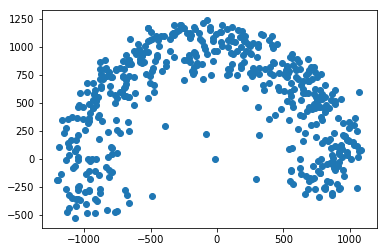

In [194]:
plt.scatter(X5[:, 0], X5[:, 1]), plt.show();

In [195]:
gmm = GMM(20, X5)

/home/krishanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log


Iteration 0, Log Likelihood -17464.6198373


/home/krishanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log


Iteration 25, Log Likelihood -17176.3543184
Iteration 50, Log Likelihood -17142.7260299
Converged


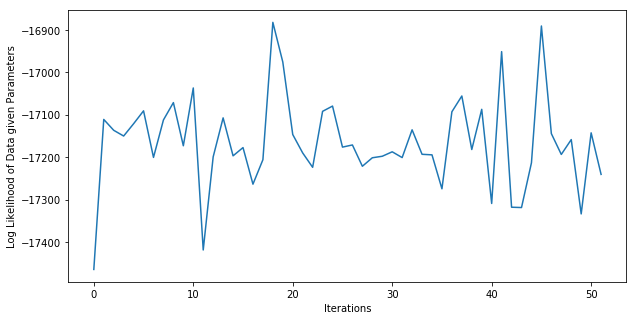

[-17464.619837267121,
 -17111.126224239964,
 -17136.703069820149,
 -17150.218498353512,
 -17121.248101430454,
 -17090.864583972812,
 -17200.597142409933,
 -17112.347919857915,
 -17071.470047694445,
 -17173.172189856698,
 -17036.990174167735,
 -17418.742116042224,
 -17199.362758770945,
 -17107.439593491537,
 -17196.899348227947,
 -17177.462379684763,
 -17263.689756286301,
 -17206.039128076165,
 -16882.358426665822,
 -16975.83367705057,
 -17146.690312498526,
 -17190.096148599783,
 -17223.941768460816,
 -17092.047534047924,
 -17079.634064556736,
 -17176.354318448077,
 -17171.270069684477,
 -17221.456576877186,
 -17201.457768221793,
 -17197.898202296728,
 -17187.396471774999,
 -17200.998042845524,
 -17135.574878009735,
 -17193.267013914192,
 -17194.591401185695,
 -17274.592235889191,
 -17093.074574477454,
 -17055.888378419575,
 -17182.010898386965,
 -17087.291501980988,
 -17309.158245214814,
 -16951.352311156821,
 -17317.973674522967,
 -17318.744547702096,
 -17213.264501139594,
 -16890.917

In [196]:
gmm.EM(500)

In [197]:
Z = gmm.generate_data(10)

In [198]:
Zn = pca.inverse_PCA(Z)

In [199]:
Zn.shape

(10, 784)

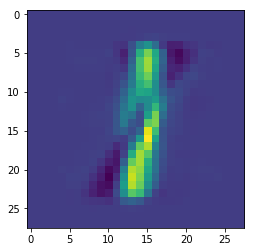

In [200]:
plt.imshow(Zn[0].reshape(28, 28)), plt.show();